# DATA*6100 FINAL PROJECT
## A neural network classifier for the Kaggle "What's Cooking?" competition

### Jason Ives

# 1. Data Pre-Processing

Before beginning data processing, I will configure the project environment, define key functions, and load the data.  Once that is complete I will construct a pipeline to manage data cleaning and encoding.

## 1.1. System Configuration

System configuration includes package imports and definition of key global constants.

In [24]:
##REFERENCES
##SOURCE: General python syntax assistance provided by Google search's AI Overview and VSCode's Python extension code completion suggestions.
##SOURCE: https://www.markdownguide.org/cheat-sheet/

##IMPORT PACKAGES - STANDARD
import os
from datetime import date
import gc

##IMPORT PACKAGES - THIRD PARTY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import compress


pd.options.mode.chained_assignment = None ##SOURCE: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas - use df.loc[...] instead of direct cell assignment to ensure data is updated

##GLOBAL CONSTANTS
##DEFINE DATA FILE LOCATIONS
dataDirectory = "data_files"
trainData = "train.json"
testData = "test.json"

##COLUMN NAMES LIST, WILL BE UPDATED WITH TRAINING COLUMNS AFTER FIT FOR USE IN TEST PREDICTIONS
trainingColumns = []

##HYPERPARAMETER STORAGE VARIABLES
lowFreqCutoff = 5

##DEFINE NUMBER OF CORES TO MAKE AVAILABLE FOR PROCESSING
numCores = max(1, os.cpu_count() // 2)


## 1.2. Functions

In this section I will define key functions, broken down into 4 main categories.

- Convenience functions
- Data processing functions
- Analysis functions
- Plot functions

### 1.2.1. Convenience functions

In [25]:
##CONVENIENCE FUNCTIONS
##WRITE TEST DATA TO FILE-------------------------------------------------------------
def WriteTestData(data, revision, byDate = True, type = "csv"):
    folderLvl1 = "submissions"
    folderLvl2 = date.today().strftime("%Y%m%d") if byDate else "Latest"
    folderLvl3 = revision

    path = os.path.join(os.getcwd(), folderLvl1, folderLvl2, folderLvl3)
    os.makedirs(path, exist_ok=True)

    ##DEFINE FILE NAME
    if type == "6100_kaggle_csv":
        fileName = "test_predictions.csv"
        writeData = f"""id,cuisine\n"""
        writeData += "\n".join([f"{row['id']},{row['cuisine']}" for index, row in data.iterrows()])
    elif type == "calculator":
        fileName = "calculator.py"
        writeData = f"""def my_answer_list():
    return({data})"""

    filePath = os.path.join(path, fileName)

    with open(filePath, 'w') as file:
        file.write(writeData)

### 1.2.2. Data processing functions

In [26]:
##RUN DATAFRAME THROUGH PIPELINE AND RETURN FORMATTED DATAFRAME-------------------------------------------------------------
def DfFromPipeline(data, steps, idToIndex = True):
    pipeline = Pipeline(steps)
    processedData = pipeline.fit_transform(data)

    if idToIndex:
        dataDf = pd.DataFrame(processedData)
    else:
        dataDf = pd.DataFrame(processedData).reset_index(drop = False)

    return(dataDf)

##SET UNSEEN INGREDIENTS TO OTHER, AND ENSURE ALL INGREDIENT COLUMNS ARE PRESENT-------------------------------------------------------------
def OtherizeUnseenIngredients(df, pipeline, keyCol, targetCol, knownIngredients):
    
    ##APPLY PIPELINE TRANFORMATION TO DATAFRAME
    df = DfFromPipeline(df, pipeline)

    ##RECODE UNSEEN INGREDIENTS AS 'OTHER'
    df.loc[~df[targetCol].isin(knownIngredients), targetCol] = "other"

    ##REAGGREGATE TO SINGLE COLUMN LIST
    df = pd.DataFrame(df.groupby(keyCol, sort = False)[targetCol].apply(list).reset_index(False))
    
    ##ADD DUMMY RECIPE TO ENSURE ALL INGREDIENT COLUMNS ARE PRESENT
    df.loc[len(df)] = [-1, knownIngredients + ['other']]
        

    return(df)

### 1.2.3. Analysis functions

In [27]:
##ANALYSIS FUNCTIONS
##SINGLE OBSERVATION DETAILS, IN A VERTICAL DISPLAY-------------------------------------------------------------
def SingleObservationDetails(obs):
    if len(obs) != 1:
        print("Only single observations are supported.")
        return
    cols = obs.columns.tolist()
    vals = obs.iloc[0].tolist()
    vertObs = pd.DataFrame({'Parameter': cols, 'Value': vals})
    display(vertObs)

##QUICK COLUMN DETAILS-------------------------------------------------------------
def QuickDetails(col):
    print("========================")
    print(f"Column: {col.name}")
    print("")
    print("Unique values:")
    [print(f"{x}") for x in col.unique()[:10]]
    if len(col.unique()) > 10:
        print("...")
    if col.dtype in ['int64', 'float64']:
        display(col.describe())
    else:
        display(col.value_counts())
    print(f"Number of nulls: {col.isnull().sum()}")
    print("========================")


##TWO COLUMN COMPARISON-------------------------------------------------------------
def TwoColCompare(df, col1, col2):
    display(df[col1].notnull().corr(df[col2] > 0))
    display(df.groupby([col1, col2]).size())

##COUNT NULLS BY COLUMN-------------------------------------------------------------
def NullCountByColumn(df):
    paramsWithNull = [(df.columns[i], df[df.columns[i]].isnull().sum()) for i in range(len(df.columns)) if (df[df.columns[i]].isnull().sum() > 0 and df.columns[i] != 'SalePrice')]
    return(pd.DataFrame(paramsWithNull, columns = ('parameter', 'nullCount')).sort_values(by='nullCount', ascending=False))

### 1.2.4. Plot functions

In [28]:
##PLOT FUNCTIONS
def QuickHist(col, bins = 20):
    plt.hist(col, bins=bins)
    plt.title(f"Histogram of {col.name}")
    plt.xlabel(col.name)
    plt.ylabel("Frequency")
    plt.show()


##CUSTOM BOXPLOT PLOT WITH FILTERING AND NORMALIZATION FOR NUMERIC-------------------------------------------------------------
def PlotNormalizedBoxplot(df, filter):
    ##FILTER VALID VALUES: 'numeric'
    if filter == 'numeric':
        scaler = StandardScaler()
        filterCols = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index.tolist()
        plt.boxplot(scaler.fit_transform(df[filterCols]), tick_labels = filterCols, vert = False)

    else:
        filterCols = df.columns.tolist()
        plt.boxplot(df[filterCols], tick_labels = filterCols, vert = False)

    plt.title("Standardized Numeric Parameter Ranges")
    plt.show()


##CUSTOM HEATMAP PLOT WITH FILTERING AND FOCUS TYPE-------------------------------------------------------------
def PlotHeatmap(df, filter, pType = 'nulls'):
    ##PTYPE VALID VALUES: 'nulls'
    ##FILTER VALID VALUES: 'numeric'
    if filter == 'numeric':
        filterCols = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index.tolist()
    else:
        filterCols = df.columns.tolist()

    if pType == 'nulls':
        plt.imshow(df[filterCols].isnull(), origin = 'lower', aspect = 'auto', interpolation = 'nearest', cmap = 'gray_r')
        plt.title("Null Value Heatmap")
        plt.show()
    elif pType == 'zeros':
        plt.imshow(df[filterCols] == 0, origin = 'lower', aspect = 'auto', interpolation = 'nearest', cmap = 'gray_r')
        plt.title("Zero Value Heatmap")
        plt.show()
    else:
        print("Invalid plot type")

In [29]:
rawTrain = pd.read_json(os.path.join(dataDirectory, trainData))
rawTest = pd.read_json(os.path.join(dataDirectory, testData))

## 1.3. Creating lists to capture transformation steps

Since I will be using a sciki-learn pipeline to manage my data preprocessing, I will create lists to capture the data transformation steps as I create them.  The lists can then be added to the pipeline after preprocessing is complete.

In [30]:
##EMPTY EMPTY STEP LISTS TO PRIME THE PIPELINES
cleaningSteps = []
encodingSteps = []

## 1.4. Data load

Loading the json data to training and test data frames.

In [31]:
##READ IN RAW TRAINING AND TEST DATA
rawTrain = pd.read_json(os.path.join(dataDirectory, trainData))
rawTest = pd.read_json(os.path.join(dataDirectory, testData))

## 1.5. Data exploration

I will explore the data structure and ranges, and ensure the outcome doesn't have any null values in the training data.

### 1.5.1. Examining the training dataframe

A quick look at the head of the training dataframe will allow me to familiarize myself with the data structure.

---

*Examining the training data reveals that the target variable is **cuisine***

*It is accompanied by a single column of ingredient lists, and an ID column*

In [32]:
display(rawTrain.head())
QuickDetails(rawTrain['id'])

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


Column: id

Unique values:
10259
25693
20130
22213
13162
6602
42779
3735
16903
12734
...


count    39774.000000
mean     24849.536959
std      14360.035505
min          0.000000
25%      12398.250000
50%      24887.000000
75%      37328.500000
max      49717.000000
Name: id, dtype: float64

Number of nulls: 0


### 1.5.2. Checking the variables for nulls and preparing the data for cleaning

I will check to see if there is any null data.  To ensure all the cases in the training data are valid, I will also check for nulls in the target / outcome variable.

---

*There are no null values in either of the columns, so data pre-processing can move forward and focus on the ingredients columns and prepare the predictor and outcome data for modeling.*

In [33]:
NullCountByColumn(rawTrain)

,parameter,nullCount


## 1.6. Data cleaning

Data cleaning for this project will focus on formatting and preparing the ingredients column for the modeling process.

### 1.6.1. Restructuring the data for data cleaning

The data needs to be broken out into separate predictor and outcome data sets.  Then the predictor data can be restructured into a long form  that will allow effective standardization of the cleaning process.

In [34]:
##PREPARE PREDICTOR DATA FOR PIPELINE MODELING
xTrain = rawTrain.drop(columns = ['cuisine'])
xTest = rawTest


##PREPARE OUTCOME DATA FOR PIPELINE MODELING
yEncoder = LabelEncoder()
yTrainEncoded = yEncoder.fit_transform(rawTrain['cuisine'])

In [35]:
##EXPAND INGREDIENTS LIST TO LONG FORMAT
def ExpandListCol(df, colName):
    longDf = df.explode(colName).reset_index(False)
    return longDf

##ADD LONG EXPANSION TO PIPELINE AND REVIEW
transformDfLong = FunctionTransformer(ExpandListCol, kw_args={'colName': 'ingredients'})

cleaningSteps.append(('expandIngredients', transformDfLong))

cleaningDf = DfFromPipeline(xTrain, cleaningSteps)

display(cleaningDf.head(10))


,index,id,ingredients
0,0,10259,romaine lettuce
1,0,10259,black olives
2,0,10259,grape tomatoes
3,0,10259,garlic
4,0,10259,pepper
5,0,10259,purple onion
6,0,10259,seasoning
7,0,10259,garbanzo beans
8,0,10259,feta cheese crumbles
9,1,25693,plain flour


### 1.6.2. Assessing the ingredients values

I will extract and review the ingredients values to check for inconsistencies, spelling issues, and variability in formatting.

---

*The ingredients column appears to be fairly clean but has a very broad range of values, 6714 total.*

*Several key things will need to be addressed:*
- *Punctuation*
- *Plural vs singular*
- *Multi-word ingredient handling*
- *Low-frequency cardinanlity*

ingredients
salt                   18049
olive oil               7972
onions                  7972
water                   7457
garlic                  7380
sugar                   6434
garlic cloves           6237
butter                  4848
ground black pepper     4785
all-purpose flour       4632
Name: count, dtype: int64

ingredients
cumberland sausage                                   1
cocktail pumpernickel bread                          1
chunky tomatoes                                      1
Colman's Mustard Powder                              1
manouri                                              1
cherry vanilla ice cream                             1
bone-in ribeye steak                                 1
frozen lemonade concentrate, thawed and undiluted    1
flowering chinese chives                             1
Kraft Slim Cut Mozzarella Cheese Slices              1
Name: count, dtype: int64

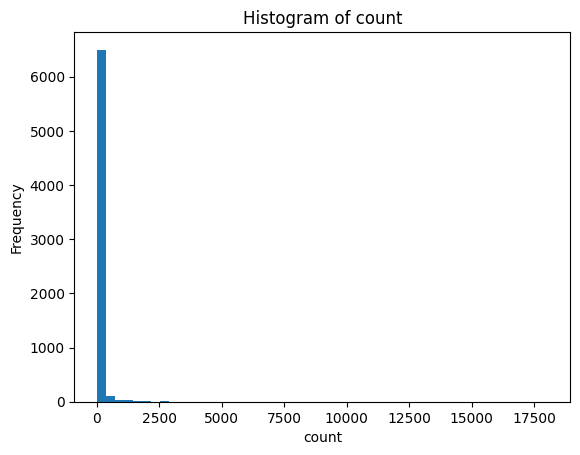

In [36]:
##REVIEW COUNTS OF INGREDIENTS
ingredientVals = cleaningDf['ingredients'].value_counts()
display(ingredientVals.head(10))
display(ingredientVals.tail(10))

len(ingredientVals)

##CHECK HISTOGRAM OF INGREDIENT COUNTS
QuickHist(ingredientVals, bins = 50)

### 1.6.3. Addressing punctuation and non-standard characters in ingredients

The ingredients column has a number of elements that use punctuation.  A review of these cases will provide context, as I look to standardize the values.

In [37]:
##CHECK FOR USAGE OF NON-STANDARD CHARACTERS IN INGREDIENT NAMES
nonStandardChars = ingredientVals[ingredientVals.index.str.contains(r'[^a-zA-Z0-9\s\-]')]
display(nonStandardChars)
display(len(nonStandardChars))

ingredients
half & half                                            337
tomato purée                                           217
1% low-fat milk                                        193
crème fraîche                                          145
cream cheese, soften                                   143
                                                      ... 
Lipton® Iced Tea Brew Family Size Tea Bags               1
Hidden Valley® Greek Yogurt Original Ranch® Dip Mix      1
Honeysuckle White® Hot Italian Turkey Sausage Links      1
Colman's Mustard Powder                                  1
frozen lemonade concentrate, thawed and undiluted        1
Name: count, Length: 225, dtype: int64

225

#### 1.6.3.1. Targeted replacement of punctuation

255 ingredient values use punctuation or other non-standard characters.  Some should be removed or replaced, while others seem key to model interpretation.  In general language specific characters will be left in place, while structural characters will be replaced or removed.

In [38]:
##TARGETED CLEANUP OF PUNCTUATION IN INGREDIENT NAMES
def PunctuationCleanup(df, colName):
    df.loc[:, colName] = df[colName].str.replace(r'&', ' and ', regex = False)
    df.loc[:, colName] = df[colName].str.replace(r'®', '', regex = False)
    df.loc[:, colName] = df[colName].str.replace(r'%', ' percent ', regex = False)
    df.loc[:, colName] = df[colName].str.replace(r'\'', '', regex = True)
    df.loc[:, colName] = df[colName].str.replace(r'™', '', regex = False)
    df.loc[:, colName] = df[colName].str.replace(r',', ' ', regex = False)
    df.loc[:, colName] = df[colName].str.replace(r'\s+', ' ', regex = True)
    df.loc[:, colName] = df[colName].str.replace(r'-', ' ', regex = False)
    df.loc[:, colName] = df[colName].str.strip()

    return(df)

##ADD PUNCTUATION CLEANUP TO PIPELINE
transformPunctuation = FunctionTransformer(PunctuationCleanup, kw_args={'colName': 'ingredients'})

cleaningSteps.append(('punctuationCleanup', transformPunctuation))

#cleaningDf = DfFromPipeline(xTrain, cleaningSteps)


### 1.6.4. Standardizing letter case

Uneven capitalization could cause otherwise equivalent values to be treated as different by the model

In [39]:
##SET ALL STRINGS TO LOWERCASE
def LowercaseIngredients(df, colName):
    df.loc[:, colName] = df[colName].str.lower()
    return(df)

##ADD LOWERCASE TRANSFORMATION TO PIPELINE
transformLowercase = FunctionTransformer(LowercaseIngredients, kw_args={'colName': 'ingredients'})

cleaningSteps.append(('setLowercase', transformLowercase))

#cleaningDf = DfFromPipeline(xTrain, cleaningSteps)

### 1.6.5. Removing plurality

Inconsistent pluarlization can also promote uneven encoding in the ingredients, so common pluarlization characters will be removed or recoded.

In [40]:
##REMOVE AND RECODE PLURAL AND RELATED VARAIATIONS TO STANDARDIZE
def RemovePlural(df, colName):
    df.loc[:, colName] = df[colName].str.rstrip(r'es')
    df.loc[:, colName] = df[colName].str.rstrip(r's')
    df.loc[:, colName] = df[colName].str.replace(r'es\s', ' ', regex = True)
    df.loc[:, colName] = df[colName].str.replace(r's\s', ' ', regex = True)
    df.loc[:, colName] = df[colName].str.replace(r'ie\s', 'y ', regex = True)
    df.loc[:, colName] = df[colName].str.replace(r'i\s', 'y ', regex = True)
    df.loc[:, colName] = df[colName].str.replace(r'ie$', 'y', regex = True)
    df.loc[:, colName] = df[colName].str.replace(r'i$', 'y', regex = True)
    
    return(df)

##ADD SPACE REMOVAL TO PIPELINE
transformPlural = FunctionTransformer(RemovePlural, kw_args={'colName': 'ingredients'})

cleaningSteps.append(('removePlural', transformPlural))

# cleaningDf = DfFromPipeline(xTrain, cleaningSteps)

### 1.6.6. Compress ingredient strings

To finalize the ingredient transformations, spaces will be removed from the ingredient strings.  This will further reduce variability among equivalent entries.

In [41]:
##COMPRESS INGREDIENT STRINGS TO REMOVE SPACES
def RemoveSpaces(df, colName):
    df.loc[:, colName] = df[colName].str.replace(r'\s+', '', regex = True).str.strip()
    return(df)

##ADD SPACE REMOVAL TO PIPELINE
transformSpacing = FunctionTransformer(RemoveSpaces, kw_args={'colName': 'ingredients'})

cleaningSteps.append(('removeSpaces', transformSpacing))

# cleaningDf = DfFromPipeline(xTrain, cleaningSteps)

## 1.7. Encoding

### 1.7.1. Recoding low frequency ingredients

Many of the ingredients occur with very low frequency.  These low frequency items can create overfitting and add noise to the model.  They also have performance overhead implications that need to be considered.  A multi-stage encoding process will work to address this.

1. Low frequency items will be identified, based on a % of total based cutoff which is a cross-validated hyperparameter.
2. Low frequency strings will be scanned for a shared ingredient phrase with the high frequency strings.  If one is found, the low frequency string will be recoded to the high frequency string.
3. If no match among the high frequency strings is found, the low frequency string will be recoded to "other".

---

*5% was found to be an optimal cutoff value during cross-validation*

In [42]:
##RECODE LOW FREQUENCY ITEMS TO OTHER OR HIGH FREQUENCY SUBSTRING MATCH
def RecodeLowFreq(df, countCol, keyCol, cutoffPct = 1):
    freqCounts = pd.DataFrame(df[countCol].value_counts().sort_values(ascending = False))
    ##ONLY RECODE FOR TRAINING DATA, DATA FOR PREDICTIONS WILL BE "OTHERIZED" SEPARATELY
    if -1 not in df[keyCol].values:
        freqCounts['cumulativePct'] = (freqCounts['count'].cumsum() / freqCounts['count'].sum()) * 100
        lowFreqIngredients = freqCounts[freqCounts['cumulativePct'] >= (100 - cutoffPct)].index.tolist()
        highFreqIngredients = freqCounts[freqCounts['cumulativePct'] < (100 - cutoffPct)].index.tolist()
        matchedHighFreqIngredients = list(compress(highFreqIngredients, [any(hf in lf for lf in lowFreqIngredients) for hf in highFreqIngredients]))
        
        ##FOR LOW FREQUENCY INGREDIENTS THAT CONTAIN A HIGH FREQUENCY SUBSTRING, RECODE TO SUBSTRING
        for ingred in matchedHighFreqIngredients:
            df.loc[df[countCol].isin(lowFreqIngredients) & df[countCol].str.contains(ingred, regex = False), countCol] = ingred

        ##ENCODE REMAINING LOW FREQUENCY INGREDIENTS AS 'OTHER'
        df.loc[df[countCol].isin(lowFreqIngredients), countCol] = "other"

    return(df)

##ADD LOW FREQUENCY DROP TO PIPELINE
transformDropLowFreq = FunctionTransformer(RecodeLowFreq, kw_args={'countCol': 'ingredients', 'keyCol': 'id', 'cutoffPct': lowFreqCutoff})

encodingSteps.append(('dropLowFrequencyIngredients', transformDropLowFreq))

# pipelineSteps = cleaningSteps + encodingSteps
# cleaningDf = DfFromPipeline(xTrain, pipelineSteps)

### 1.7.2. Encode the long-form data into wide-form

The long-form ingredient data must be converted to a wide format for modeling.  In this phase the ingredients column will be one-hot encoded to create a sparse long and wide table, one with the encodings for each recipe spread out among a number of lines.  In the next step this table will be compressed into a one-row-per-observation format.

---

*WARNING: Do not attmpt to view this data frame outside of the pipeline, it is very large and can cause crashing and other performance issues.*

In [43]:
##ONE HOT ENCODE THE INGREDEIENTS.  NOT YET COMPRESSED INTO ONE ROW PER RECIPE
def OneHotEncoderWrapper(dfLong, targetCol, keyCol):
    ohEncoder = OneHotEncoder(handle_unknown = 'ignore', drop = None)
    encodedIngredients = ohEncoder.fit_transform(dfLong[[targetCol]])

    dfLongWide = pd.DataFrame(encodedIngredients.toarray(), columns = ohEncoder.get_feature_names_out([targetCol]))
    dfLongWide.insert(loc = 0, column = keyCol, value = dfLong[keyCol].values)

    return(dfLongWide)

oneHotIngredients = FunctionTransformer(OneHotEncoderWrapper, kw_args={'targetCol': 'ingredients', 'keyCol': 'id'})

encodingSteps.append(('oneHotIngredients', oneHotIngredients))

### 1.7.3. Compress long data into a single row per observation

The long and wide format can now be compressed to reduce the length to 1 row per observation.

In [44]:
##COMPRESS ROWS TO SINGLE ROW PER RECIPE
def CompressRows(df, keyCol):
    df = df.groupby(df[keyCol], sort = False).max()

    return(df)

compressRows = FunctionTransformer(CompressRows, kw_args={'keyCol': 'id'})

encodingSteps.append(('compressRows', compressRows))

# pipelineSteps = cleaningSteps + encodingSteps
# cleaningDf = DfFromPipeline(xTrain, pipelineSteps)

### 1.7.4. Creating a neural network autoencoder for dimension reduction

The training data set with 5% of values recoded has over 1700 features.  This can affecting hardware performance, and I'm concerned it could be an issue for the model as well.  To do some testing with dimension reduction, I will create a prototype neural network autoencoder.  This will be a single layer neural network that transforms the features to a reduced dimension hidden layer, then decodes them back to the size of the original feature set.  The resulting output features are scored to assess how closely they resemble the inupts, using the binary cross entropy score (BCE).  The neural network then executes a training loop, working to improve that BCE score.  Once the training loop is complete, the weights and biases used to create the final hidden layer are extracted, and used to transform the data set into a lower dimension.

This autoencoder will be added to the modeling pipeline so the hyperparameters can be tuned and it's best fit can be stored by the pipeline.  My hope is that the resulting data set will have comparable modeling performance, and run more quickly and while consuming less hardware resources.

---

*The autoencoder was succesfully intergrated into the pipeline for parameter validation, but the cross entropy loss was significantly worse than the full feature set model across all hyperparameter tuning runs.  The best validation score came from a model with a very high number of features (little dimension reduction).  It had a negative CEL of **-1.287**, compared to a negative CEL of a bit over **1.0** for equivalently configured validation models with no dimension reduction, more than 20% worse than the baseline.*

*In addition, despite attempts at optimization, the cross-validation phase with the full training data set could not be executed with the autoencoder in the pipeine.  The operating system could not allocate sufficient reasources.  As such, the autoencoder has been removed from the modeling pipelines.  It can still be tested using step 1.7.4.1.*

In [45]:
##AMPLE CREDIT TO GOOGLE GEMINI [FAST] FOR STEP BY STEP INSTRUCTIONAL

##TAKING A SHOT AT A NEURAL NETWORK AUTOENCODER CLASS FOR DIMENSION REDUCTION
class AutoencoderPrototype(BaseEstimator, TransformerMixin):
    def __init__(self, nHiddenLayer = 50, eta = 5e-8, epochs = 25):
        if epochs > 50:
            print("Warning: More than 50 epochs may lead to excess sparsity.  Limiting to 50.")
            epochs = 50

        self.nHiddenLayer = nHiddenLayer
        self.eta = eta
        self.epochs = epochs
        
        ##INITALIZE WEIGHTS AND BIASES IN INIT SO THEY PERSIST FOR LATER TRANSFORMS
        self.encodeWeights = None
        self.encodeBiases = None
        self.decodeWeights = None
        self.decodeBiases = None

        ##INITIALIZE LOSS DATAFRAME
        self.lossData = pd.DataFrame(columns = ['iteration', 'bceLoss'])

    ##FIT METHOD TO ESTABLISH WEIGHTS AND BIASES
    def fit(self, df, y = None):
        inputMatrix = df.values if isinstance(df, pd.DataFrame) else df
        if self.nHiddenLayer > inputMatrix.shape[1]:
            self.nHiddenLayer = inputMatrix.shape[1] - 1
        
        nFeatures = inputMatrix.shape[1]
        nObservations = inputMatrix.shape[0]

        ##INITIALIZE WEIGHTS AND BIASES
        self.encodeWeights = np.random.rand(nFeatures, self.nHiddenLayer) * .01
        self.encodeBiases = np.zeros((1, self.nHiddenLayer))
        self.decodeWeights = np.random.rand(self.nHiddenLayer, nFeatures) * .01
        self.decodeBiases = np.zeros((1, nFeatures))

        for iteration in range(self.epochs):
            ##-=FORWARD PASS=-
            ##CREATE HIDDEN LAYER WITHOUT RELU TRANFORMATION
            hiddenLayer = np.dot(inputMatrix, self.encodeWeights) + self.encodeBiases
            
            ##APPLY RELU ACTIVATION FUNCTION
            hiddenLayerActivated = self._relu(hiddenLayer)

            ##CREATE OUTPUT LAYER WITHOUT SIGMOID TRANFORMATION
            outputLayer = np.dot(hiddenLayerActivated, self.decodeWeights) + self.decodeBiases

            ##ACTIVATE OUTPUT LAYER (SIGMOID)
            outputLayerActivated = 1 / (1 + np.exp(-outputLayer))



            ##-=BACKWARD PASS=-
            ##CALCULATE ERROR (BCE LOSS FUNCTION)
            outputError = outputLayerActivated - inputMatrix

            ##CALCULATE DECODER GRADIENTS
            dDecodeWeights = np.dot(hiddenLayerActivated.T, outputError)
            dDecodeBiases = np.sum(outputError, axis = 0, keepdims = True)

            ##CALCULATE ERROR PASSED OUTPUT TO HIDDEN LAYER
            decoderToHiddenError = np.dot(outputError, self.decodeWeights.T)

            ##DEFINE RELU GRADIENT
            reluGradient = np.where(hiddenLayer > 0, 1, 0)

            ##CALCULATE ERROR PASSED FROM HIDDEN LAYER TO ENCODER WEIGHTS AND BIASES
            hiddenToEncoderError = decoderToHiddenError * reluGradient

            ##CALCULATE ENCODER GRADIENTS
            dEncodeWeights = np.dot(inputMatrix.T, hiddenToEncoderError)
            dEncodeBiases = np.sum(hiddenToEncoderError, axis = 0, keepdims = True)

            ##UPDATE WEIGHTS AND BIASES USING GRADIENT DESCENT
            self.encodeWeights -= self.eta * dEncodeWeights
            self.encodeBiases -= self.eta * dEncodeBiases
            self.decodeWeights -= self.eta * dDecodeWeights
            self.decodeBiases -= self.eta * dDecodeBiases

            ##CALCULATE AND PRINT BCE LOSS EVERY 10 ITERATIONS
            bceLoss = -np.mean(inputMatrix * np.log(outputLayerActivated + 1e-10) + (1 - inputMatrix) * np.log(1 - outputLayerActivated + 1e-10))
            self.lossData.loc[self.lossData.shape[0]] = [iteration + 1, bceLoss]

        return self

    ##TRANSFORM METHOD TO CREATE UPDATED DATAFRAME
    def transform(self, df):
        ##TRANSFORM DF USING TRAINED WEIGHTS AND BIASES
        transformationMatrix = df.values if isinstance(df, pd.DataFrame) else df
        reducedDim = self._relu(np.dot(transformationMatrix, self.encodeWeights) + self.encodeBiases)
        reducedDim = pd.DataFrame(reducedDim)
        reducedDim.columns = [f"dim_{i+1}" for i in range(reducedDim.shape[1])]
        reducedDim.index = df.index
        return(reducedDim)
    
    ##OUTPUT BCE LOSS INFO AND PLOT LOSS OVER TIME
    def metrics(self):
        plt.plot(self.lossData['iteration'], self.lossData['bceLoss'])
        plt.title("BCE Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("BCE Loss")
        plt.show()
    
    ##RELU HELPER METHOD
    def _relu(self, z):
        return np.maximum(0, z)

#### 1.7.4.1. Tuning the eta step size and epoch parameters

To ensure that the autoencoder is able to improve the model over all epochs without overstepping a minimum point and being set to 0 by the ReLU function, I will use the BCE loss score of each epoch to assess the threshold for overstepping - indicated by a sharp decline in BCE loss.  I will then adjuste the eta and number of epochs to balance performance, sparsity, and accuracy.

---

*After testing the following values were set:*

- *eta: 5e-8*
- *epochs: capped at 50*

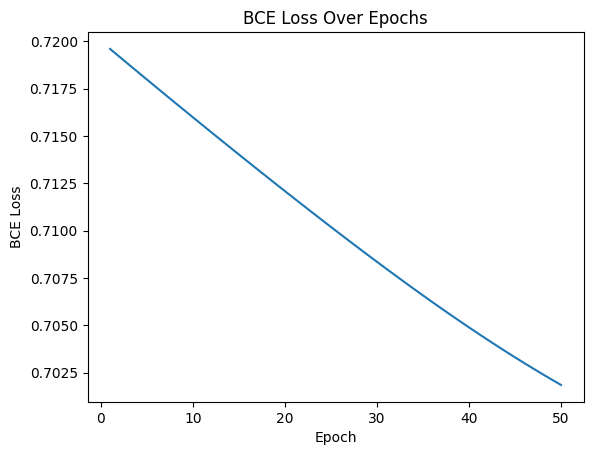

16149

In [46]:
##TEST / DEMO AUTOENCODER ETA AND EPOCH TUNING
pipelineSteps = cleaningSteps + encodingSteps
cleaningDf = DfFromPipeline(xTrain, pipelineSteps)

dimReducer = AutoencoderPrototype(nHiddenLayer = 200, eta = 5e-8, epochs = 51)
test = dimReducer.fit_transform(cleaningDf.iloc[0:cleaningDf.shape[0]//20])

dimReducer.metrics()

##FREE UP MEMORY
del cleaningDf
gc.collect()

### 1.7.5. Finalize the preprocessing pipeline steps

To prepare for modeling the preprocessing pipeline steps can be combined.

In [47]:
##COMBINE CLEANING AND ENCODING STEPS INTO A SINGLE PIPELINE
pipelineSteps = cleaningSteps + encodingSteps

# 2. Modelling

## 2.1. Create a neural network classifier

My primary model will be a neural network classifier.  I will use a 30% stratified sample to execute a grid cross-validated version of the model pipeline for hyperparameter tuning.  The optimized parameter values will then be passed to a final modeling pipeline.  That pipeline will first be used to model and predict 5-fold cross-validated data sets, for review of the modeling metrics.  Then the full training set will be used to fit the final modeling pipeline and make predictions based on the test data.

### 2.1.1. Process the training data

The training data will be processed using the cleaning and encoding pipeline.

In [48]:
##RUN TRAINING DATA THROUGH CLEANING / ENCODING PIPELINE
xTrainFormatted = DfFromPipeline(xTrain, pipelineSteps, idToIndex = True)

### 2.1.2. Establish the modeling parameters

Before the modeling phase I will create a grid cross-validated model to refine the hyperparameters associated with the mlp classifier.  To avoid performance issues I will use a subset of the data to find the best combination of the hyperparameters, and use those values for the full modeling process.

#### 2.1.2.1. Subset the training data for model parameterization

The pre-processed training data will then be split using 70% / 30%.  The 70% sample will be discarded and the 30% sample will be used for grid cross-validated parameter tuning.

In [49]:
##TAKE A 10% SAMPLE FOR PARAMETER TUNING
xDummy, xTrainParam, yDummy, yTrainParam = train_test_split(xTrainFormatted, yTrainEncoded, test_size = 0.3, stratify = yTrainEncoded, random_state = 9)

##DELETE UNEEDED DFS
del xDummy
del yDummy
gc.collect()


2041

#### 2.1.2.2. Instantiate the neural network classifier

The multilayer perceptron classification model for the parameterization pipeline is defined.

In [50]:
##INSTANTIATE MLP MODEL
paramModel = MLPClassifier(hidden_layer_sizes=(200,), 
                            activation='relu', 
                            max_iter=500, 
                            random_state=1, 
                            early_stopping=True, 
                            n_iter_no_change=10)

#### 2.1.2.3. Create hyperparmeter tuning pipeline 

The parameterization pipeline is created using the previously instantiated classifier.

In [51]:
##CREATE PARAMETERIZATION PIPELINE
parameterizationPipeline = Pipeline([
    ('paramClassifier', paramModel)
])

#### 2.1.2.4. Define the hyperparameter tuning cross-validation grid

Values for the size and number of hidden layers, as well as the alpha smoothing parameter, are defined here, for assessment during cross-validation.

---

*A broader range of values was tested over several testing cycles.  The values below represent a narrowed range of optimized values for the final cross-validation cycle to assess.*

In [52]:
mlpParameterGrid = {
    ##MLP CLASSIFIER PARAMETERS
    ##REDUCED ONCE OPTIMAL PARAMETERS WERE IDENTIFIED
    # 'paramClassifier__hidden_layer_sizes': [(400,), (500,), (600,), (700,), (800,), (900,), (1000,), (1100,), (1200,), (1300,)],
    # 'paramClassifier__alpha': [0.0001, 0.001, 0.01]
    'paramClassifier__hidden_layer_sizes': [(500,), (600,), (700,)], 
    'paramClassifier__alpha': [0.0001, 0.001]
    }

#### 2.1.2.5. Execute cross-validation for hyperparameter tuning

With the parameters and pipeline in place, the cross-validation cycle can begin.

In [53]:
stratKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

paramGrid = GridSearchCV(
    estimator = parameterizationPipeline, 
    param_grid = mlpParameterGrid, 
    cv = stratKFold, 
    scoring = ['neg_log_loss', 'accuracy'],
    refit = 'neg_log_loss', 
    n_jobs = numCores
)

paramGrid.fit(xTrainParam, yTrainParam)

,estimator,Pipeline(step...om_state=1))])
,param_grid,"{'paramClassifier__alpha': [0.0001, 0.001], 'paramClassifier__hidden_layer_sizes': [(500,), (600,), ...]}"
,scoring,"['neg_log_loss', 'accuracy']"
,n_jobs,8
,refit,'neg_log_loss'
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,hidden_layer_sizes,"(600,)"


#### 2.1.2.6. Review the results of the hyperparameter tuning cycle

Once the cross-validation process is complete, the results of the tuning cycle can be reviewed.  Reviewing this in aggregate can be informative and help in identifying patterns of strong or weak factors across the different validation runs.  These patterns of strength or weakness can help guide the set of hyperparamter values to be used in subsequent cycles.

---

*After the full tuning pass, the range of cross-validation parameters was narrowed for performance reasons.  The full results plot is loaded from file here:*
![Full range cross-validation plot](images/mlp_cv_results_01.png)

Best Mean Cross Entropy Loss: -0.8625825636231529


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_paramClassifier__alpha,param_paramClassifier__hidden_layer_sizes,params,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,...,std_test_neg_log_loss,rank_test_neg_log_loss,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
4,140.096494,5.758295,0.521187,0.046393,0.0010,"(600,)","{'paramClassifier__alpha': 0.001, 'paramClassi...",-0.866261,-0.840681,-0.863283,...,0.025946,1,0.747801,0.757017,0.734395,0.747276,0.753562,0.748010,0.007719,1
3,122.917276,8.892743,0.471339,0.012432,0.0010,"(500,)","{'paramClassifier__alpha': 0.001, 'paramClassi...",-0.873963,-0.843775,-0.880402,...,0.030166,2,0.754085,0.749895,0.736908,0.742246,0.748533,0.746334,0.006052,4
0,123.416832,8.698970,0.438667,0.028130,0.0001,"(500,)","{'paramClassifier__alpha': 0.0001, 'paramClass...",-0.873724,-0.843419,-0.880807,...,0.030496,3,0.754085,0.749057,0.736908,0.742666,0.747276,0.745998,0.005833,6
1,138.457693,6.994077,0.523172,0.019858,0.0001,"(600,)","{'paramClassifier__alpha': 0.0001, 'paramClass...",-0.865819,-0.888762,-0.862897,...,0.024954,4,0.748220,0.752828,0.735233,0.746857,0.751886,0.747005,0.006290,2
5,118.817941,15.252375,0.304084,0.079246,0.0010,"(700,)","{'paramClassifier__alpha': 0.001, 'paramClassi...",-0.913266,-0.832950,-0.859410,...,0.030317,5,0.749895,0.758274,0.737746,0.743085,0.745599,0.746920,0.006905,3
2,168.843865,16.699910,0.589206,0.031498,0.0001,"(700,)","{'paramClassifier__alpha': 0.0001, 'paramClass...",-0.913992,-0.832747,-0.892845,...,0.030309,6,0.750314,0.758274,0.732719,0.743923,0.745599,0.746166,0.008366,5


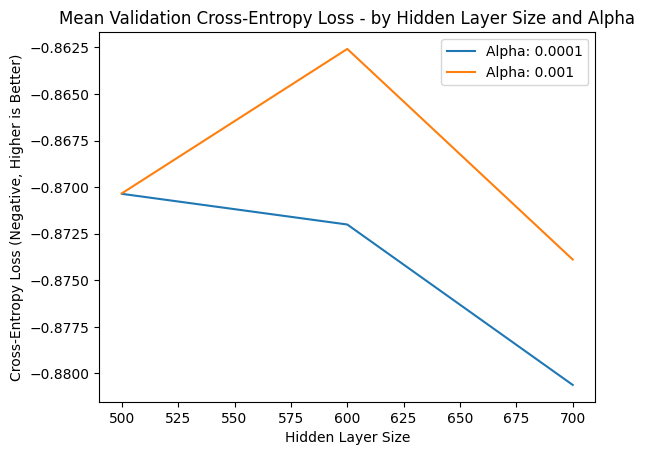

In [54]:
##DISPLAY RESULTS DF AND BEST CE SCORE
paramCvResults = pd.DataFrame(paramGrid.cv_results_)
print(f"Best Mean Cross Entropy Loss: {paramCvResults['mean_test_neg_log_loss'][paramCvResults['rank_test_neg_log_loss'] == 1].values[0]}")
display(paramCvResults.sort_values(by='rank_test_neg_log_loss').head(10))

##DISPLAY A PLOT OF MEAN TEST LOG LOSS BY HIDDEN LAYER SIZE, BROKEN OUT BY ALPHA
for alpha in mlpParameterGrid['paramClassifier__alpha']:
    subsetResults = paramCvResults[paramCvResults['param_paramClassifier__alpha'] == alpha]
    plt.plot(subsetResults['param_paramClassifier__hidden_layer_sizes'].apply(lambda x: x[0]), subsetResults['mean_test_neg_log_loss'], label = f'Alpha: {alpha}')
plt.title("Mean Validation Cross-Entropy Loss - by Hidden Layer Size and Alpha")
plt.xlabel("Hidden Layer Size")
plt.ylabel("Cross-Entropy Loss (Negative, Higher is Better)")
plt.legend()
plt.show()


#### 2.1.2.7. Extract parameters from parameterization model

The best hyperparameter values can finally be extracted from the cross-validation pipeline, and passed to the final modeling pipeline for use in modeling the full training data set.

In [55]:
##PARAMETER TRANSFER FROM PARAMETERIZATION GRID TO FINAL MODEL
finalHiddenLayers = paramGrid.best_params_['paramClassifier__hidden_layer_sizes']
finalAlpha = paramGrid.best_params_['paramClassifier__alpha']

##CLEAN UP PARAMETERIZATION OBJECTS
del paramGrid
del parameterizationPipeline
del paramModel
del xTrainParam
del yTrainParam
gc.collect()

4021

### 2.1.3. Defining the final model

The final model and pipeline can now be defined, using the optimal parameters established in the previous steps.  This pipeline will be used for both the final cross-validation steps, and full final model fitting.

In [56]:
##INSTANTIATE THE FINAL MODEL
finalModel = MLPClassifier(activation='relu', 
                           max_iter=500, 
                           random_state=1, 
                           early_stopping=True, 
                           n_iter_no_change=10, 
                           hidden_layer_sizes=finalHiddenLayers, 
                           alpha=finalAlpha)

##DEFINE THE FINAL MODEL PIPELINE
finalModelPipeline = Pipeline([
    ('finalClassifier', finalModel)
    ])

### 2.1.4. cross-validating the final model

To get a sense of the performance of the final model using the optimized parameters and the full set of training data, one final cross-validation will be run.  This will provide cross entropy loss and accuracy scores for validation data, and is a good way to get a sense of how the model will perform on unseen data.

In [57]:
##cross-valIDATE THE FINAL MODEL TO ASSESS OVERALL PERFORMANCE
finalCvScores = cross_validate(
    estimator = finalModelPipeline, 
    X = xTrainFormatted, 
    y = yTrainEncoded, 
    cv = stratKFold, 
    scoring = ['neg_log_loss', 'accuracy'],
    n_jobs = numCores)

#### 2.1.4.1. Review the cross-validation results

The cross-entropy loss and accuracy of the final cross-validation model are checked, to confirm final model performance on unseen data.

---



In [58]:
##DISPLAY cross-validation METRICS
print(f"Validation cross-entropy loss: {np.mean(finalCvScores['test_neg_log_loss'])}")
print(f"Validation accuracy: {np.mean(finalCvScores['test_accuracy'])}")

Validation cross-entropy loss: -0.7680586842725612
Validation accuracy: 0.7742747858640989


### 2.1.5. Train the full-data model

After confirming model performance using cross-validation, the final model can be fit using the full training data set.

In [59]:
##FIT THE FINAL FULL TRAINING DATA MODEL
finalModelPipeline.fit(xTrainFormatted, yTrainEncoded)

,steps,"[('finalClassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,hidden_layer_sizes,"(600,)"
,activation,'relu'
,solver,'adam'
,alpha,0.001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001


# 3. Final test predictions and wrap-up

With model validation and fitting complete, the training data can now be processed by the model and predictions can be generated.

## 3.1. Extract feature names for test data configuration

To ensure a uniform structure between the training and test data sets, the column names from the training data must be transferred to the test data.

In [60]:
trainingColumns = xTrainFormatted.columns.tolist()

trainingColumns = [item.replace('ingredients_', '') for item in trainingColumns if 'ingredients_' in item]

## 3.2. Final predictions

The test data must be pre-processed using the cleaning and encoding pipeline.  Once that is done the final model pipeline can be used to generate predictions based on the model.  Those predictions will be label encoded, so they will need to be inverse transformed to represent the cuisine categories.

Once the formatting is done the final test predictions can be output to file for submission to Kaggle.

---

*Final kaggle submission score: **.77353***

*The leaderboard is locked, but if it were active and in the same state it is in now, leaderboard position would be **778**.*

In [61]:
###FORMAT TEST DATA (OTHERIZE TO MATCH OHE COLUMNS, THEN RUN PIPELINE)
xTestFormatted = DfFromPipeline(OtherizeUnseenIngredients(xTest, cleaningSteps, 'id', 'ingredients', trainingColumns), pipelineSteps, idToIndex = True)

##RUN AND DECODE TEST PREDICTIONS
testPredsEncoded = finalModelPipeline.predict(xTestFormatted)
xTestFormatted['cuisine'] = yEncoder.inverse_transform(testPredsEncoded)

#REMOVE DUMMY RECIPE PREDICTION
xTestFormatted = xTestFormatted.reset_index(drop = False)
xTestFormatted = xTestFormatted.loc[xTestFormatted['id'] != -1]

##OUTPUT TEST PREDICTIONS TO FILE
WriteTestData(xTestFormatted[['id', 'cuisine']], revision = "Rev1", byDate = True, type = "6100_kaggle_csv")